# Reviews Analyzer

The objective of this analysis is threefold:
1. Word association identification
2. Contextual sentiment extraction
3. Theme/topic assignment to word clusters

The dataset used for the purpose of this analysis consists of [hotel reviews](https://code.google.com/archive/p/dataset/downloads) mined from [Tripadvisor.com](http://tripadvisor.com)

### Lets load the data
Hotel reviews are available for the cities of Beijing, Chicago, Dubai, Las-Vegas, London, Montreal, New-Delhi, New-York-City, San-Francisco and Shanghai spanning the years 2003 - 2010. For the purpose of this analysis, the city has been set to *chicago* and year to *2007*. These settings however **can** be changed. 

In [1]:
# Load necessary libraries
import numpy as np
import nltk

# Load custom module
import helperFunctions as hf

# Read Hotel Reviews Data into a data frame
dataPath = 'OpinRankDataSet/hotels/'
city = 'chicago'
year = '2007'
hotelReviewCount, reviewsDF = hf.readReviewsData(dataPath, city, year)
print('Done reading data')

Done reading data


In [ ]:
# Load custom module
import helperFunctions as hf

### Clean up the text
Cleaning mainly involves removal of noisy characters, stopwords, case normalization and stemming. A mapping is also created between words and their stemmed forms, so that extracting the actual word is possible.

In [2]:
# Create combined reviews corpus from all reviews for different applications
combinedCorpus = reviewsDF['FullReview'].str.cat(sep=' ')
corpusOnlyChar = hf.preprocessText(combinedCorpus,onlyChar=True,lower=True,stopw=False,stem=False)
corpusNoStop   = hf.preprocessText(corpusOnlyChar,onlyChar=False,lower=False,stopw=True,stem=False)
corpusStem     = hf.preprocessText(corpusNoStop,onlyChar=False,lower=False,stopw=False,stem=True)
print('Done corpus processing')

# Create the unstem dictionary for the corpus
unstemDict = {}
corpusTrim = np.array(corpusNoStop.split())
hf.unstem(corpusTrim,unstemDict)
corpusTrim = list(corpusTrim)
print('Done creating unstem dictionary')

Done corpus processing
Done creating unstem dictionary


### A quick look at the most frequent terms in the corpus

Here is a list of the top-most occurring words in the corpus:


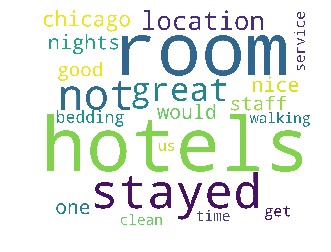

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Extract the most frequent words (excluding stopwords)
cleanReview = reviewsDF['FullReview'].apply(hf.preprocessText)
mostFreqWords = hf.getMostFrequentWords(cleanReview,unstemDict,5)

print('Here is a list of the top-most occurring words in the corpus:')
freqWordsDict = mostFreqWords[:20].to_dict()['Count']
freqCloud = WordCloud(background_color='white',
                      width=1000,
                      height=800,
                      scale = 5,
                      random_state=10,
                      min_font_size=6).generate_from_frequencies(freqWordsDict)
plt.imshow(freqCloud)
plt.axis('off')
plt.show()

### Word Association

Although word association has many connotations, it can be broadly classified into two types:
1. **Paradigmatic Association**: These words are associated because they appear in a similar context. Paradigmatically associated words can be used interchangeably in a sentence without affecting its semantics. Eg: "I bumped into my friend while on my way to work". Here *work* can be replaced with *college* without affecting the semantic correctness of the sentence.
2. **Syntagmatic Association**: These words are associated because they are typically collocated. Syntagmatically associated words often occur together in a sentence. Eg: "The person at the front desk assited me". The words *front desk* are collocated and often occur together.

Both these associations have been mined for in the reviews.

#### Paradigmatic Association
Paradigmatic associations have been mined by looking at the context around words for window size upto 3. Results obtained by including and excluding stopwords have been combined (stopwords like prepositions and determinants can help while looking at context).

Here is an example for paradigmatically associated words in the corpus. The example word **breakfast** can be replaced with another word to finds its associations in the corpus

Here is a list of words associated with breakfast


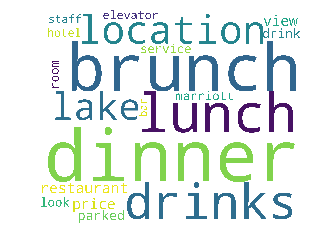

In [5]:
# Find Similar Words (appearing in similar contexts)
from nltk import ContextIndex
corpusOnlyChar = hf.preprocessText(combinedCorpus,onlyChar=True,lower=True,stopw=False,stem=False)
reviewContextFull3W = ContextIndex(tokens=corpusOnlyChar.split(),context_func=hf.contextFunc3W)
reviewContextFull2W = ContextIndex(tokens=corpusOnlyChar.split(),context_func=hf.contextFunc2W)
reviewContextStop2W = ContextIndex(tokens=corpusNoStop.split(),context_func=hf.contextFunc2W)

word = 'breakfast' #<------------change word here to see other associations
similarWords = hf.getSimilarWords(word, reviewContextFull3W, reviewContextFull2W, reviewContextStop2W, numWords=20)

similarWords = similarWords.to_dict()
similarWordsDict = [similarWords[di] for di in similarWords][0]
print('Here is a list of words associated with '+ word)
freqCloud = WordCloud(background_color='white',
                      width=1000,
                      height=800,
                      scale = 5,
                      random_state=10,
                      min_font_size=6).generate_from_frequencies(similarWordsDict)
plt.imshow(freqCloud)
plt.axis('off')
plt.show()

#### Syntagmatic Association
Syntagmatic associations have been mined by looking at how frequently do bi-grams occur in the corpus. The bi-grams need not be coniguous. Stop words have been ignored.

Here is an example for syntagmatically associated words in the corpus. The top ten most frequently occurring bi-grams are shown.

Here is a list of top frequently occurring collocated words


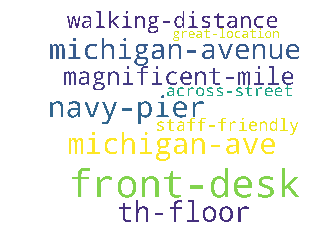

In [4]:
# Find Collocated Words (words appearing together in a phrase)
from nltk.collocations import BigramCollocationFinder
windowSize = 3 # Increase this parameter to discover more spaced out bi-grams. Typically syntagmatic words lie in close proximity
finder = BigramCollocationFinder.from_words(corpusStem.split(), windowSize)
collocationWords = hf.getCollocatedWords(finder,unstemDict,numPairs=10)

print('Here is a list of top frequently occurring collocated words')
freqCloud = WordCloud(background_color='white',
                      width=1000,
                      height=800,
                      scale = 5,
                      random_state=10,
                      min_font_size=6).generate_from_frequencies(collocationWords)
plt.imshow(freqCloud)
plt.axis('off')
plt.show()

### Contextual Sentiment Analysis
Contextual sentiments are typically extracted from smaller phrases which could have either a postive, negative or neutral sentiment. So, there could be many different sentiments expressed in the same paragraph of text. From a *reviews* perspective, it make sense to look at what aspect of the product/service was the consumer happy/unhappy about. That is exactly what is being done in this analysis.


Since the dataset at our disposal is not labelled for sentiment, a rule-based classifier *(VADER-Valence Aware Dictionary and sEntiment Reasoner)* is used to extract sentiments from each sentence. Once the sentiment is known, the *object* that the sentiment is referring to is identified by looking for nouns and noun phrases. This is further filtered by comparing with a list of frequently occuring noun words in the corpus that could be associated with either a product or service. The sentiments are then aggregated from the entire review.

Have a look!

In [21]:
# Find Contextual Sentiments
cleanReview = reviewsDF['FullReview'].apply(hf.preprocessText)

# Get a list of frequent terms that could be associated with the domains (in this case 'hotel') product/service
mostFreqWords = hf.getMostFrequentWords(cleanReview,unstemDict,minThresh=5)
posTaggedWords = nltk.pos_tag(list(mostFreqWords.index))
hotelWords = [w for w,tag in posTaggedWords if tag == 'NN']

# Select a review and identify the associated sentiments
REVIEW = reviewsDF['FullReview'][80] #<---------------- Pick another review by chaning the index value
reviewSentiments = hf.getContextualSentiment(REVIEW, domainWords = hotelWords)
print('Sentiments expressed in this review:\n' + REVIEW)
reviewSentiments

Sentiments expressed in this review:
Great Hotel. This is a nice hotel in a great location. I had heard that the rooms were so small as to be laughable, but our room was not small at all. The concierge was very helpful, and the hotel was clean and attractive. If you're claustrophobic, you might want to avoid the elevators. I would definitely stay there again.


{'a great location': 'positive',
 'a nice hotel': 'positive',
 'claustrophobic': 'negative',
 'elevators': 'negative',
 'room': 'neutral',
 'the concierge': 'positive'}

### Theme/Topic Identifcation
The objective here is to assign a theme to a cluster of associated words extracted from the corpus. The words could be describing a related phenomenon. There are two steps here: 
1. To identify clusters of associated terms. This is done by first building a TFIDF matrix of frequently occuring terms and the contexts in which they occur. K-means is then used to partition these terms into clusters that are homogenous.
2. Once the clusters of terms are obtained, the theme/subject/topic that each term in the cluster could be referring to is identified. This is done with the help of the WordNet lexicon. For each term all the hyponyms (parent terms from which the term is derived) are identified. Then the parent term that is most common across all the terms in the cluster is chosen as the theme for the cluster. This seems to work pretty well.

Lets have a look at the clusters and what themes they are ascribing to.

In [27]:
# Get similar word clusters along with topic
cleanReview = reviewsDF['FullReview'].apply(hf.preprocessText,stopw=True,minLen = True)
cleanReview = cleanReview.str.cat(sep=' ')
maxClusters = 10
clusterDict = hf.getThemeClusters(cleanReview,mostFreqWords,unstemDict,maxClusters)

# Modify cluster dict for plotting
clusterList = []
for dic in clusterDict:
    themeList = [(dic,5)]
    termList = [(term,1) for term in clusterDict[dic]]
    themeList.extend(termList)
    themeDict = dict(themeList)
    clusterList.append(themeDict)
    
print('Here is a list of top frequently occurring collocated words')
numClusters = len(clusterList)
f, sbplts = plt.subplots(2,5)
plotCount = 0
for i in range(5):
    for j in range(5):
        termCloud = WordCloud(background_color='white',
                      width=1000,
                      height=800,
                      scale = 3,
                      random_state=10,
                      min_font_size=6).generate_from_frequencies(clusterList[plotCount])
        sbplts[i,j].imshow(termCloud)
        sbplts[i,j].axis('off')
        plotCount = plotCount+1
        if plotCount == numClusters:
            print(plotCount)
            break
            
plt.show()

Here is a list of top frequently occurring collocated words


IndexError: list index out of range

In [28]:
plotCount

6